In [2]:
from copy import deepcopy

def get_cfg_clusters(run_lst, cluster_cfg_lst):
    run_lst_cp = deepcopy(run_lst)
    cfgs= [run_lst_cp[ix].config for ix in range(len(run_lst_cp))]

    for ix in range(len(cfgs)):
        for key in cluster_cfg_lst:
            del cfgs[ix][key]

    selected_id = list()
    cluster_lst = list()

    for ix in range(len(cfgs)):
        if ix not in selected_id:
            cluster_lst.append([ix])
            selected_id.append(ix)
            for iy in range(ix+1,len(cfgs)):
                if cfgs[ix]==cfgs[iy]:
                    cluster_lst[-1].append(iy)
                    selected_id.append(iy)

    
    return cluster_lst

In [3]:
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline, interp1d


def compute_norm_integral_metric(ratio, score, benchmark_score):
    f = interp1d(ratio, score)
    metric = quad(f, ratio[0], ratio[-1])[0] \
        /((ratio[-1]-ratio[0])*benchmark_score)
    return metric

In [13]:
import wandb
import pandas as pd 

api = wandb.Api()
#runs = api.runs("kit-iai-ibcs-dl/derma_ssl/gj0ge845")
runs = api.sweep("kit-iai-ibcs-dl/derma_ssl/gj0ge845").runs


cluster_lst_seed_labeled_ratio = get_cfg_clusters(runs, ["experiment.seed", "data.datamodule.arguments.initial_labeled_ratio"])

print(cluster_lst_seed_labeled_ratio)



[[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270, 288, 306, 324, 342, 360, 378, 396, 414, 432, 450, 468, 486, 504, 522, 540, 558, 576, 594, 614], [1, 19, 37, 55, 73, 91, 109, 127, 145, 163, 181, 199, 217, 235, 253, 271, 289, 307, 325, 343, 361, 379, 397, 415, 433, 451, 469, 487, 505, 523, 541, 559, 577, 595, 617], [2, 20, 38, 56, 74, 92, 110, 128, 146, 164, 182, 200, 218, 236, 254, 272, 290, 308, 326, 344, 362, 380, 398, 416, 434, 452, 470, 488, 506, 524, 542, 560, 578, 596, 615], [3, 21, 39, 57, 75, 93, 111, 129, 147, 165, 183, 201, 219, 237, 255, 273, 291, 309, 327, 345, 363, 381, 399, 417, 435, 453, 471, 489, 507, 525, 543, 561, 579, 597, 616], [4, 22, 40, 58, 76, 94, 112, 130, 148, 166, 184, 202, 220, 238, 256, 274, 292, 310, 328, 346, 364, 382, 400, 418, 436, 454, 472, 490, 508, 526, 544, 562, 580, 598, 613], [5, 23, 41, 59, 77, 95, 113, 131, 149, 167, 185, 203, 221, 239, 257, 275, 293, 311, 329, 347, 365, 383, 401, 419, 437, 455, 473, 491, 509, 527, 545, 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

result_lst = list()

for cluster in cluster_lst_seed_labeled_ratio:
    values_dict={}
    df = pd.DataFrame(columns=["ratio", "seed", "score"])
    for run_index in cluster:
        run_i = runs[run_index]
        df = df.append({
            "ratio": run_i.config["data.datamodule.arguments.initial_labeled_ratio"], 
            "seed": run_i.config["experiment.seed"] , 
            "score": run_i.summary["test/score"]}, 
            ignore_index=True)

    seeds = np.unique(df["seed"].to_numpy())

    df = df.sort_values(by=["ratio"])

    result_dict = dict()
    result_dict["ratio"] = list()
    result_dict["score"] = list()

    for seed in seeds:
        result_dict["ratio"].append(df[df["seed"]==seed]["ratio"].to_numpy())
        result_dict["score"].append(df[df["seed"]==seed]["score"].to_numpy())

    result_dict["cfg"] = run_i.config

    result_lst.append(result_dict)

In [5]:
def select_results(result_lst, selection_dict):
    filtered_result_lst = list()
    for res in result_lst:
        cfg = res["cfg"]
        match = True
        for key, value in selection_dict.items():
            if cfg[key] != value:
                match = False
                break
        
        if match:
            filtered_result_lst.append(res)

    return filtered_result_lst


In [22]:
from scipy.stats import ttest_ind 

def ssl_t_test(random, ssl, benchmark_score):
    random_metric = list()
    ssl_metric = list()

    for i in range(len(ssl["ratio"])):
        ssl_metric.append(compute_norm_integral_metric(ssl["ratio"][i], ssl["score"][i], benchmark_score))
        random_metric.append(compute_norm_integral_metric(random["ratio"][i], random["score"][i], benchmark_score))

    return ttest_ind(random_metric, ssl_metric, alternative='less').pvalue, np.mean(random_metric), np.mean(ssl_metric) 

In [26]:
benchmark_score = 0.8217

ssl_methods = dict()

selection_dict = dict()
selection_dict["model.params.encoder_frozen"] = True

selection_dict["model.params.pretraining_weights"] = None
random = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/moco/dnn_weights.ckpt"
ssl_methods["moco"] = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/densecl/dnn_weights.ckpt"
ssl_methods["densecl"] = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/modeco/dnn_weights.ckpt"
ssl_methods["modeco"] = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "imagenet"
ssl_methods["imagenet"] = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/byol/dnn_weights.ckpt"
ssl_methods["byol"] = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/barlow_twins/dnn_weights.ckpt"
ssl_methods["barlow_twins"] = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/detco/dnn_weights.ckpt"
ssl_methods["detco"] = select_results(result_lst, selection_dict)[0]

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/simclr/dnn_weights.ckpt"
ssl_methods["simclr"] = select_results(result_lst, selection_dict)[0]


for key,value in ssl_methods.items(): 
    print(key)
    p_value, mean_random, mean_ssl = ssl_t_test(random, value, benchmark_score)
    print(f"p-val: {p_value}, mean ssl: {mean_ssl}, mean random: {mean_random}")
    print("\n")












moco
p-val: 2.407707955796626e-06, mean ssl: 0.9603583634187041, mean random: 0.9190640340783238


densecl
p-val: 2.3866281814787716e-06, mean ssl: 0.9629926252830614, mean random: 0.9190640340783238


modeco
p-val: 0.0001341568125323907, mean ssl: 0.9587608789348302, mean random: 0.9190640340783238


imagenet
p-val: 4.350084373073318e-06, mean ssl: 0.9538593496732902, mean random: 0.9190640340783238


byol
p-val: 5.5039252983591466e-05, mean ssl: 0.9494684577811279, mean random: 0.9190640340783238


barlow_twins
p-val: 0.019263428758223403, mean ssl: 0.928017559666545, mean random: 0.9190640340783238


detco
p-val: 0.9910915407070491, mean ssl: 0.9026710799330763, mean random: 0.9190640340783238


simclr
p-val: 8.413423173273828e-06, mean ssl: 0.9563638844350691, mean random: 0.9190640340783238




In [136]:
selection_dict = dict()
selection_dict["model.params.encoder_frozen"] = True

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/moco/dnn_weights.ckpt"
moco = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/densecl/dnn_weights.ckpt"
densecl = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = None
random = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/modeco/dnn_weights.ckpt"
modeco = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = "imagenet"
imagenet = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/byol/dnn_weights.ckpt"
byol = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/barlow_twins/dnn_weights.ckpt"
barlow_twins = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/detco/dnn_weights.ckpt"
detco = select_results(result_lst, selection_dict)

selection_dict["model.params.pretraining_weights"] = "/lsdf/kit/iai/projects/iai-aida/Daten_Schilling/2022_SSL_experiments/ssl_weights/simclr/dnn_weights.ckpt"
simclr = select_results(result_lst, selection_dict)

Text(0.5, 1.0, 'Frozen')

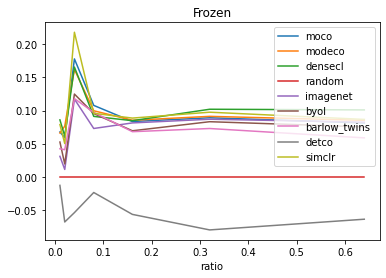

In [137]:
moco_score = np.array(sorted(moco[0]["mean"].items()))
modeco_score = np.array(sorted(modeco[0]["mean"].items()))
random_score = np.array(sorted(random[0]["mean"].items()))
imagenet_score = np.array(sorted(imagenet[0]["mean"].items()))
densecl_score = np.array(sorted(densecl[0]["mean"].items()))
byol_score = np.array(sorted(byol[0]["mean"].items()))
barlow_twins_score = np.array(sorted(barlow_twins[0]["mean"].items()))
detco_score = np.array(sorted(detco[0]["mean"].items()))
simclr_score = np.array(sorted(simclr[0]["mean"].items()))

df = pd.DataFrame(moco_score.copy(), columns=['ratio', 'moco']) 
df["moco"] = df["moco"]/random_score[:,1]-1
df["modeco"] = modeco_score[:,1]/random_score[:,1]-1
df["densecl"] = densecl_score[:,1]/random_score[:,1]-1
df["random"] = random_score[:,1]/random_score[:,1]-1
df["imagenet"] = imagenet_score[:,1]/random_score[:,1]-1
df["byol"] = byol_score[:,1]/random_score[:,1]-1
df["barlow_twins"] = barlow_twins_score[:,1]/random_score[:,1]-1
df["densecl"] = densecl_score[:,1]/random_score[:,1]-1
df["detco"] = detco_score[:,1]/random_score[:,1]-1
df["simclr"] = simclr_score[:,1]/random_score[:,1]-1

df.plot(x="ratio")
plt.title("Frozen")

In [112]:
def compute_norm_integral_metric(ratio_score_array, benchmark_score):
    f = interp1d(ratio_score_array[:,0], ratio_score_array[:,1])
    score = quad(f, ratio_score_array[0,0], ratio_score_array[-1,0])[0] \
        /((ratio_score_array[-1,0]-ratio_score_array[0,0])*benchmark_score)
    return score

0.9410239741502584


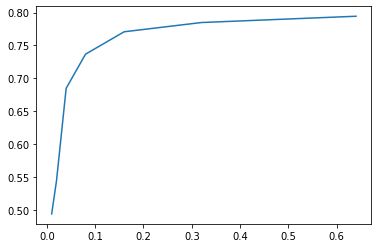

In [139]:

plt.plot(moco_score[:,0], moco_score[:,1])

benchmark_score = 0.8217


print(compute_norm_integral_metric(densecl_score,benchmark_score))